In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats


In [3]:
# A normal continuous random variable.
# The location (loc) keyword specifies the mean.
# The scale (scale) keyword specifies the standard deviation.
means_dist_1 = stats.norm(loc = 0, scale = 1)
means_dist_2 = stats.norm(loc = 3, scale = 2)

# A beta continuous random variable.
variance_dist = stats.beta(a=8, b=2, scale = 50/4)
print([means_dist_1.var(), means_dist_2.var()])
print(variance_dist.mean())

[1.0, 4.0]
10.0


In [4]:
def calculate_regression(var_vec = [means_dist_1.var(), means_dist_2.var()], mue = variance_dist.mean(), 
                         n_list = [10, 20, 30], w_list = [0.2, 0.4, 0.6], 
                         v_mat = [[0.1, 0.6, 0.3], [0.2, 0.8, 0.0], [0.3, 0.5, 0.2]], 
                         x_vec = [1.0, 1.0]):

    '''
    Calculate exact error for linear regression, in special case where x-distribution is 0-mean multivariate 
    normal. Assumes the parameters have 0 correlation (parameter in 1st dimension is independent of parameter 
    in 2nd dimension, for example). 

    Args:
        var_vec: a list with variance of true parameter values
        mue: mean of true error distribution.
        n_list: a list of length M (number of players) with the number of samples each has.
        w_list: a list of w-weights each player uses (in [0, 1]) for coarse-grained federation.
        v_mat: a matrix (list of lists) of weights each player uses in fine-grained federation: the rows sum up 
            to 1.
        x_vec: a list of E[X_d^2] for d in dimension D for input distribution of X.
    Returns:
        dataframe with average error for each player, for: local, uniform, coarse-grained, and fine-grained 
        federation.
    '''

    # dataframe for storing error
    player_error = pd.DataFrame(data = 0.0, index = ['local', 'uniform', 'coarse', 'fine'],
                                columns = range(len(n_list)))
    N = sum(n_list)
    D = len(var_vec)
    n_vec = pd.DataFrame(n_list)

    # for each player, calculate their true error 
    for i in range(len(w_list)):
        w = w_list[i]
        n = n_list[i]
        v_vec = pd.DataFrame(v_mat[i])

        # local
        player_error.loc['local'][i] = mue * D/(n - D - 1)

        # uniform
        var_prod = pd.DataFrame(x_vec).T.dot(pd.DataFrame(var_vec))[0][0]

        player_error.loc['uniform'][i] = ((mue * D * (n_vec**2).T.dot(1/(n_vec- D -1))/(N**2))[0][0] + 
                                          var_prod*((n_vec**2).sum() - n**2 + (N- n)**2)[0]/(N**2))

        # coarse-grained
        player_error.loc['coarse'][i] = ((mue*D *(1-w)**2 * (n_vec**2).T.dot(1/(n_vec- D -1))/(N**2))[0][0] + 
                                         mue*D*(w**2 + 2 * (1-w) * w*n/N)/(n-D-1) + 
                                         (1-w)**2*var_prod*((n_vec**2).sum() - n**2 + (N- n)**2)[0]/(N**2))    

        # fine-grained
        player_error.loc['fine'][i] = (mue * D * (v_vec**2).T.dot(1/(pd.DataFrame(n_list)- D -1))[0][0] + 
                                       var_prod * ((v_vec**2).sum() - v_vec[0][i]**2 + (1 - v_vec[0][i])**2)[0])

    return player_error

In [5]:
# calculate_regression()

In [19]:
def simulate_regression(params_dists = [means_dist_1, means_dist_2],
                        err_dist = variance_dist,
                        draws_dist = stats.norm,
                        n_list = [10, 20, 30],
                        w_list = [0.2, 0.4, 0.6],
                        v_mat = [[0.1, 0.6, 0.3], [0.2, 0.8, 0.0], [0.3, 0.5, 0.2]],
                        world_nrun = 100,
                        sample_nrun = 1,
                        test_nrun = 10,
                        x_cov = [[1.0, 0.0], [0.0, 1.0]]):
    '''
    Simulate regression.

    Args:
        params_dists: length-D list of distributions to draw parameters from.
        err_dist: distribution to draw true error parameters from (err = epsilon^2) (scalar).
        draws_dist: distribution each player draws from: with mean*X as mean and variance epsilon^2.
        n_list: a list of length M (number of players) with the number of samples each has.
        w_list: a list of w-weights each player uses for coarse-grained federation.
        v_mat: a matrix (list of lists) of weights each player uses in fine-grained federation: the rows sum up 
               to 1.
        world_nrun: number of times where means and errors are re-drawn.
        sample_nrun: for each worldrun, number of times samples are re-drawn.
        test_nrun: for each sample_nrun, number of points we use to calculate expected test error.
        x_cov: matrix representing covariance of input x distribution.

    Returns:
        dataframe with average error for each player, for local, uniform, coarse-grained, and fine-grained 
        federation.
    '''

    M = len(w_list)  # w_list: a list of w-weights each player uses for coarse-grained federation.
    n_list_pd = pd.DataFrame(n_list)  # n_list: a list of length M (number of players) with the number of samples each has.
    w_list_pd = pd.DataFrame(w_list)
    v_mat_pd = pd.DataFrame(v_mat)

    D = len(x_cov)
    mean_x = np.array([0] * D)
    x_dist = stats.multivariate_normal(mean = mean_x, cov = x_cov)

    # dataframe for storing error
    player_error = pd.DataFrame(data = 0, index = ['local', 'uniform', 'coarse', 'fine'], 
                                columns = range(len(n_list)))


    for _ in range(world_nrun):
        # draw means and errors
        means = pd.DataFrame([dist.rvs(M) for dist in params_dists]).T
        errors = err_dist.rvs(M)

        print(f'{means}\n')
        print(f'{errors}')

        for _ in range(sample_nrun):
            # draw samples for each player, calculate local estimates
            local_est = pd.DataFrame(0, columns = range(D), index = range(M))
            for i in range(M):
                # draw X values
                X = pd.DataFrame(x_dist.rvs(n_list[i]))

                print(f'\nX:\n{X}')

                # draw Y values noisily
                Y = [
                        draws_dist(
                            loc = X.dot(means.iloc[i])[j],  # mean of this player
                            scale = np.sqrt(errors[i])  # error of this player
                        ).rvs() for j in range(n_list[i])
                    ]

                print(f'\nY:\n{Y}')

                print(f'\n\n{means.iloc[i]}\n\n')

                plt.scatter(X[0], Y)
                plt.show()

                # calculate local estimates through OLS
                to_invert = X.T.dot(X)
                df_inv = pd.DataFrame(np.linalg.pinv(to_invert.values), to_invert.columns, to_invert.index)
                local_est.iloc[i] = df_inv.dot(X.T).dot(Y)

            # calculate federated estimates
            uniform_est = local_est.T.dot(n_list_pd)/sum(n_list)
            coarse_est = (local_est * w_list_pd.values + 
                          (1-w_list_pd).values * pd.concat([uniform_est.T]*M, ignore_index=True)) 
            fine_est = local_est.T.dot(v_mat_pd.T).T

            # calculate expected MSE
            X = pd.DataFrame(x_dist.rvs(test_nrun)) # draw test input data
            if test_nrun ==1:
                X = X.T

            player_error.loc['local'] += ((X.dot(means.T) - X.dot(local_est.T))**2).sum()
            player_error.loc['uniform'] += ((X.dot(means.T) - 
                                 X.dot(pd.concat([uniform_est.T] * M, ignore_index=True).T))**2).sum()
            player_error.loc['coarse'] += ((X.dot(means.T) - X.dot(coarse_est.T))**2).sum()
            player_error.loc['fine'] += ((X.dot(means.T) - X.dot(fine_est.T))**2).sum()

    player_error = player_error/(world_nrun * sample_nrun * test_nrun)

    return player_error

          0         1
0 -0.249242  5.174835
1  0.568497  4.530510
2  0.799649  2.448953

[10.03146673 11.2234289  11.3221042 ]

X:
          0         1
0  1.317976 -0.173531
1  1.279135  1.134503
2  0.866665  0.076871
3 -0.232822  0.066531
4 -0.735323  0.072102
5  0.054599 -0.964197
6  1.061898  0.862216
7  0.130054 -0.190763
8  0.064798 -0.360553
9  1.144198 -0.757137

Y:
[-4.61657161337577, -1.3415547991463024, -1.8917892836403318, -6.03997926232448, 4.105230451169045, -10.144032589106398, 5.60520788490069, -2.792145065309936, -2.8515613471331664, -6.93295597367037]


0   -0.249242
1    5.174835
Name: 0, dtype: float64




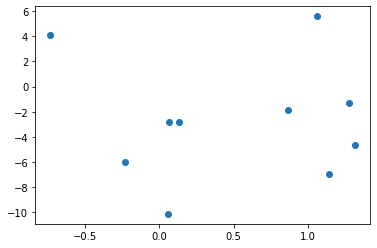


X:
           0         1
0  -0.127151 -0.441057
1  -0.866818  0.405892
2   1.306169 -0.532866
3  -0.225087 -0.790560
4  -0.418587 -1.152258
5   0.491550  1.041657
6   0.211544  3.100783
7  -0.898841  1.657052
8   0.044968 -1.254056
9  -0.313386  0.830612
10  0.594035  1.646781
11 -0.162052 -0.812324
12 -0.406766 -0.008906
13 -0.854559 -1.100994
14  1.521911 -0.743105
15 -0.826664  0.466041
16 -0.081989 -0.984991
17 -1.166760  0.617005
18 -0.769213  0.942580
19 -0.309128 -0.699814

Y:
[-4.487509109322588, 3.320320718520545, -2.648484791361249, -8.229609009557015, -6.801060355639394, 9.919346434738083, 11.43696541175175, 5.777776365974983, -7.053727403837962, 6.583530787594449, 9.139850791786499, -11.191770450596294, 3.001838298129015, -4.186934201721801, -4.772448719121789, -2.0990183146003973, -2.707406417669831, 4.28846633659934, 1.3949492832669224, -3.3577298661991715]


0    0.568497
1    4.530510
Name: 1, dtype: float64




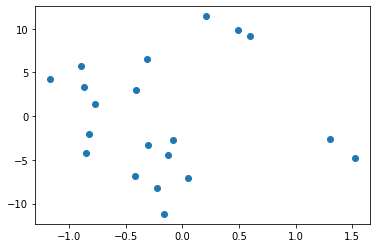


X:
           0         1
0  -1.186390 -0.229158
1   0.128523  0.260475
2  -1.770712 -0.580724
3  -0.432493 -1.202109
4  -2.628129  0.866438
5  -0.278645 -0.484650
6  -1.986183  0.707060
7   0.031085 -1.235727
8  -0.201994  0.515771
9   0.622563 -0.403510
10 -0.714559  0.782342
11  0.365218 -0.685763
12  0.810321 -3.192615
13 -1.240859 -2.273746
14  0.362353  0.177860
15  0.830969 -1.047066
16  0.324763  0.252569
17  2.146699  0.665784
18 -0.635971 -1.344061
19 -0.037732 -1.446119
20 -0.338850 -1.515633
21 -0.479509  1.868941
22 -1.425621  2.210043
23  0.007016 -1.824614
24  0.340933  1.188247
25 -1.536314 -1.629427
26  1.512858 -0.030024
27 -1.396915 -1.667885
28 -0.642601 -0.548925
29  0.744426 -0.393049

Y:
[2.492304716789503, 1.6250891498961817, -0.6840925304474639, -5.7681393335335445, 10.499402912430506, -0.7253243461699312, 0.8902434520697347, 0.3383407470509545, 4.774838351833191, 4.9130506447562485, 4.238981104667728, -8.308426979290557, -11.36727309480608, -10.87916100356330

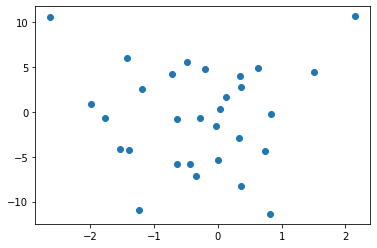

,0,1,2
local,15.132642,0.058305,1.389873
uniform,0.193397,1.121919,4.154366
coarse,0.490421,0.445674,2.315397
fine,0.357410,1.283079,7.326004


In [20]:
simulate_regression(world_nrun = 1)

In [8]:
calculate_regression()

,0,1,2
local,2.857143,1.176471,0.740741
uniform,5.673047,4.006380,2.339714
coarse,3.897417,1.818768,0.818799
fine,6.818768,1.267227,5.480890
